## 설정

In [63]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 4.1 선형 회귀
모델을 훈련시킨다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것이다.  

### 4.1.1 정규방정식
비용 함수를 최소화하는 $θ$를 찾아주는 공식


$\hat{Θ} = (X^TX)^{-1}X^Ty$

이 공식을 테스트해 본다.

In [64]:
import numpy as np

# 선형처럼 보이는 데이터 생성
X = 2 * np.random.rand(100, 1)  # 100x1 크기의 0~1 사이의 값으로 이루어진 값을 리턴
y = 4 + 3 * X + np.random.randn(100, 1)  # 100x1 크기의 정규분포를 따르는 값을 리턴

.rand() : Random values in a given shape  
.randn() : Return a sample from the "standard normal" distribution

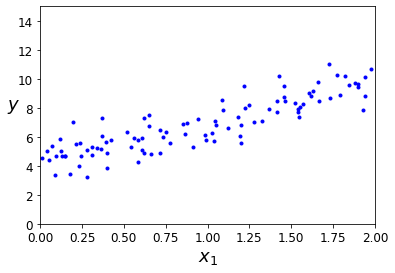

In [65]:
# 그래프 그리기

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [66]:
# 선형 데이터를 생성했고 이제 정규방정식을 이용해 세타햇을 계산한다

X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0=1을 추가한다
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [67]:
theta_best

array([[4.21509616],
       [2.77011339]])

이 데이터를 생성하기 위해 사용한 함수는 y = 4 + 3x + 가우시안_잡음 이었다.  
즉 세타0 = 4, 세타1 = 3이 나오길 기대했는데 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지는 못했다.  
이제 구한 $\hat{θ}$을 사용해 예측을 해본다.  ($\hat{y}$ = X$\hat{θ}$)

In [68]:
# 구한 세타^을 사용해 예측

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0=1을 추가한다
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

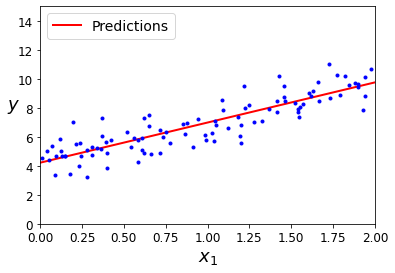

In [69]:
# 모델의 예측을 그래프로 나타낸다.

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [70]:
# 사이킷 런에서 선형 회귀를 수행한다

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_  # .intercept_(편향), .coef_(가중치)

(array([4.21509616]), array([[2.77011339]]))

In [71]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

정규방정식을 통해 구한 세타로 예측한 값과 일치한다.

In [72]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 쓴다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산한다.  
$\mathbf{X}^{+}$는 $\mathbf{X}$의 유사역행렬 (pseudoinverse).  
np.linalg.pinv()을 사용해서 유사역행렬을 직접 구할 수 있다.

In [73]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

정규방정식을 계산하는 것보다 유사역행렬을 이용하는 방식이 훨씬 효율적이다.  
역행렬이 없는 경우 정규방정식은 작동하지 않지만 유사역행렬은 항상 구할 수 있다.

## 4.2 경사 하강법
경사 하강법의 기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것.  
파라미터 벡터$\theta$에 대해 비용 함수의 현재 그레이디언트를 계산하고 그레이디언트가 감소하는 방향으로 진행한다.  
경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다.

### 4.2.1 배치 경사 하강법
매 스텝에서 **전체 훈련 세트**를 사용해 그레이디언트를 계산한다.

In [74]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  # 초기값은 랜덤으로 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [75]:
theta

array([[4.21509616],
       [2.77011339]])

정규방정식으로 찾은 값과 동일하다.

In [76]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

세 가지 다른 학습률을 사용하여 경사 하강법을 진행한다.

In [77]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

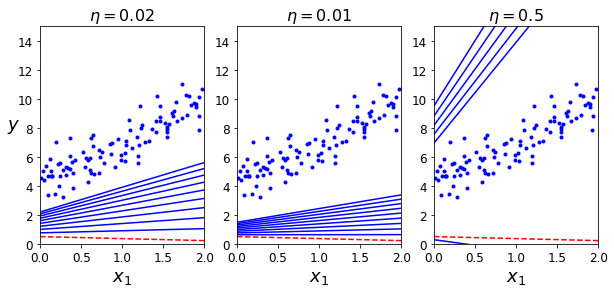

In [78]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize = (10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(132); plot_gradient_descent(theta, eta = 0.01, theta_path = theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta = 0.5)

plt.show()

### 4.2.2 확률적 경사 하강법
매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트를 계산한다.

In [79]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

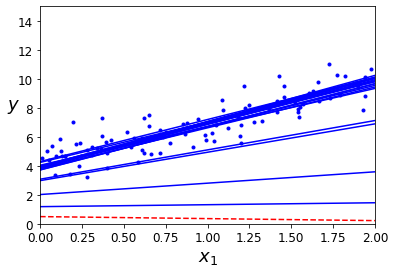

In [80]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):  # 학습 스케줄 : 학습률을 결정하는 함수
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)  # 랜덤으로 섞은 인덱스 중 하나 선택
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  # 그레이디언트 계산 
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients  # 세타 업데이트
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [81]:
theta

array([[4.21076011],
       [2.74856079]])

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용한다.

In [82]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1, random_state = 42)
# 최대 1000번 에포크 실행, 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행, 학습률은 0.1
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [83]:
sgd_reg.intercept_, sgd_reg.coef_
# 결과를 보면 정규방정식으로 구한 것과 매우 비슷하다.

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법
미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산한다.
확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상이다.

In [84]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffeled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):  # FOR문이 돌 때 미니배치 사이즈만큼씩
        t += 1
        xi = X_b_shuffeled[i:i + minibatch_size]  # 미니배치 사이즈만큼씩
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [85]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [86]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

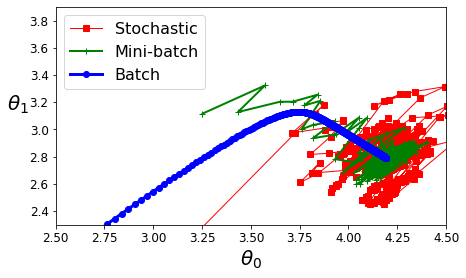

In [87]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])

plt.show()

## 4.3 다항 회귀  
주어진 데이터가 단순한 직선보다 복잡한 형태, 비선형 데이터인 경우 이를 학습하는 데 선형 모델을 사용할 수 있다.  
각 특성의 거듭제곱을 새로운 특성으로 추가하고 이 확장된 데이터셋에 선형 모델을 훈련시키는 것이다.  

In [88]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [89]:
# 약간의 잡음을 포함하는 비선형 데이터를 생성한다.
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)  

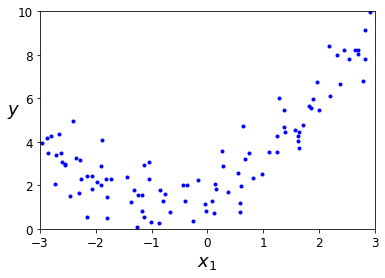

In [90]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([-3, 3, 0, 10])
plt.show()

위의 데이터를 잘 표현할 수 있는 직선은 없다.  
따라서 사이킷런의 PolynomialFeatures로 훈련 데이터를 변환한다.  
훈련 세트의 각 특성을 제곱해서 새로운 특성으로 추가한다.  

In [91]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [92]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [93]:
# 이 확장된 훈련 데이터에 Linear Regression을 적용한다.

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

즉, 0.56x^2 + 0.93x + 1.78 로 모델을 예측했다는 의미

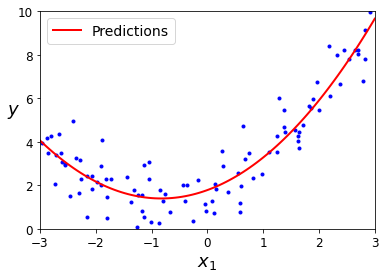

In [94]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc = "upper left", fontsize = 14)
plt.axis([-3, 3, 0, 10])
plt.show()

특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있다. (일반적인 선형 회귀 모델에서는 하지 못한다.)  

## 4.4 학습 곡선

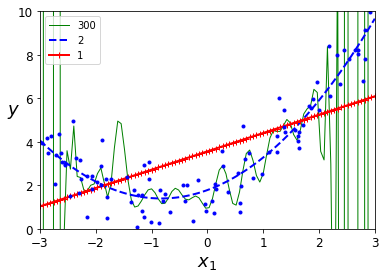

In [95]:
# 고차 다항 회귀 그래프로 나타내기

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree = degree, include_bias = False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()


선형 모델, 2차 다항 회귀 모델, 300차 다항 회귀 모델로 갈수록 훨씬 더 훈련 데이터에 잘 맞추려한다.  
위의 그래프를 보면 300차 다항 회귀 모델은 훈련 샘플에 가능한 한 가까이 가려고 구불구불하게 나타난다.  
즉, 고차 다항 회귀 모델은 훈련 데이터에 과대적합되기 쉽다.    
반면 선형 모델은 과소적합이다.    
위의 경우 일반화가 가장 잘될 모델은 2차 다항 회귀다.  

In [96]:
# 주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):  # m개의 서브세트로 나눠서 여러 번 훈련한다.
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

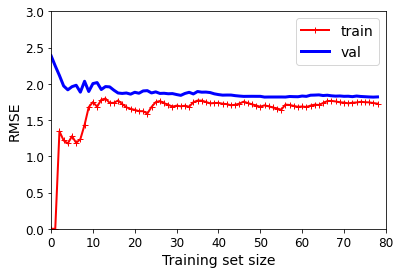

In [97]:
# 단순 선형 회귀 모델의 학습 곡선을 살펴본다.

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과소적합 모델의 전형적인 학습곡선 

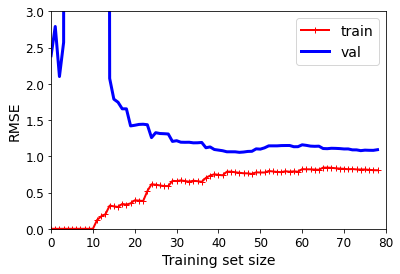

In [98]:
# 위와 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선을 그려본다.

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()


- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다.
- 두 곡선 사이에 공간이 있다. -> 훈련 데이터에서의 성능이 검증 데이터에서보다 훨씬 낫다. -> "과대적합"  
- 하지만 더 큰 훈련 세트를 사용하면 두 곡선은 점점 가까워진다.

## 4.5 규제가 있는 모델
### 4.5.1 릿지 회귀

In [99]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

_*np.linspace(start, stop, num) 함수  
linspace는 Linearly Spaced의 줄임말  
start 숫자부터 stop 숫자까지를 num개의 요소로 만든 1차원 배열을 반환한다._

In [100]:
# 사이킷런에서 정규방정식을 사용한 릿지 회귀

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = "cholesky", random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [101]:
ridge_reg = Ridge(alpha = 1, solver = "sag", random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

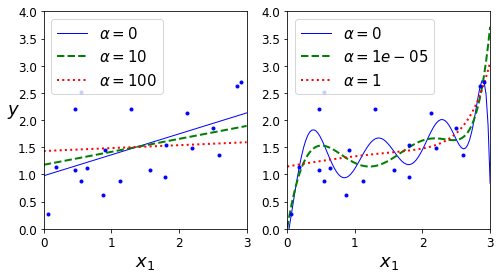

In [102]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

$\alpha$를 증가시킬수록 직선에 가까워진다. 

In [103]:
# 확률적 경사 하강법을 적용한 경우

sgd_reg = SGDRegressor(penalty = "l2", max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### 4.5.2 라쏘 회귀  
릿지 = l2노름  
라쏘 = l1노름

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


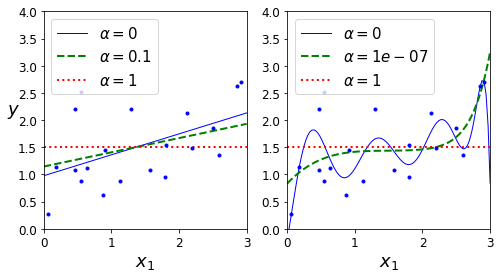

In [104]:
from sklearn.linear_model import Lasso

plt.figure(figsize = (8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial = False, alphas = (0, 0.1, 1), random_state = 42)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [105]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

# Lasso 대신 SGDRegressor(penalty = "l1")을 사용할 수도 있다.

array([1.53788174])

### 4.5.3 엘라스틱넷

In [106]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5, random_state = 42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 조기 종료

In [107]:
# 데이터 준비하기

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size = 0.5, random_state = 10)

In [108]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

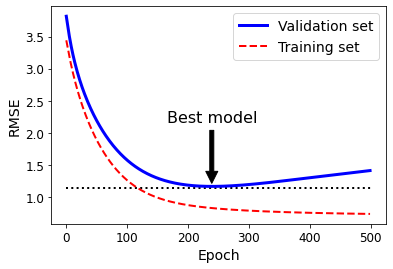

In [109]:
# 그래프 그리기

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [110]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [112]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

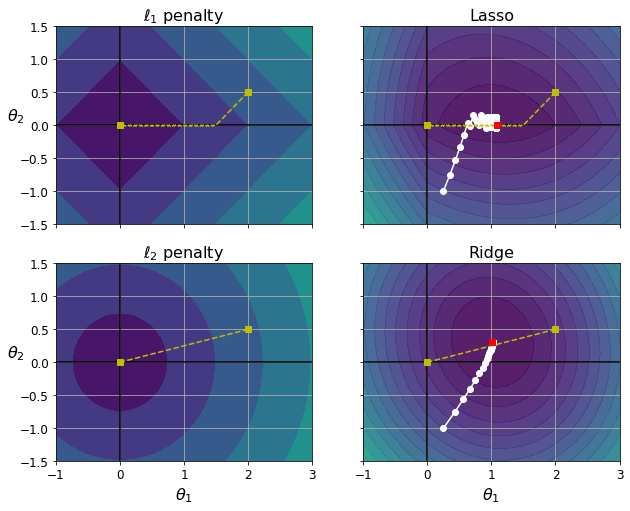

In [113]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

## 4.6 로지스틱 회귀
### 4.6.1 확률 추정

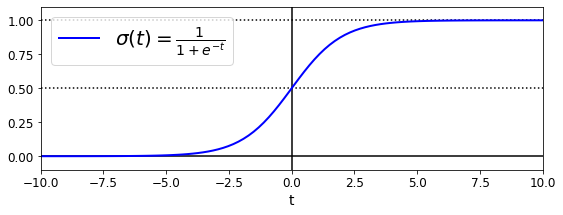

In [114]:
# 시그모이드 함수 그래프

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

plt.show()

### 4.6.3 결정 경계
꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기를 만들어 본다.

In [115]:
# 먼저 데이터를 로드한다.

from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [116]:
print(iris.DESCR)
# print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [117]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris-Virginica면 1, 그렇지 않으면 0

In [118]:
# 로지스틱 모델 훈련

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = "lbfgs", random_state = 42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

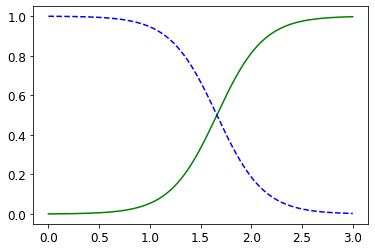

In [119]:
# .fit 메서드로 모델을 만들었고
# 꽃잎의 너비가 0~3인 꽃에 대해 모델의 추정 확률을 계산해 본다.

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label = "Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label = "Not Iris virginica")

_.predict() vs .predict_proba_
- predict() : 는 수치 그대로 선형회귀에서 쓰는 것, (0, 1 같이 클래스 값!)
- predict_proba() : 는 나온 수치를 확률(로지스틱?)로 바꾸는 것, 로지스틱 회귀에서 쓰는 것

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


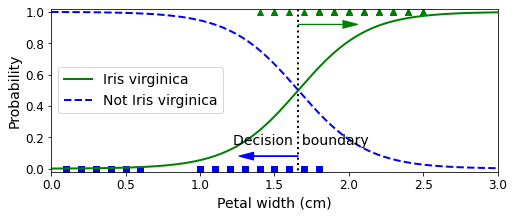

In [57]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

In [58]:
# 결정 경계
# : 클래스를 예측할 때 양쪽 확률이 똑같이 50%가 되는 곳
decision_boundary

array([1.66066066])

In [59]:
# 1.6 기준으로 클래스가 달라진다.

log_reg.predict([[1.7], [1.5]])

array([1, 0])

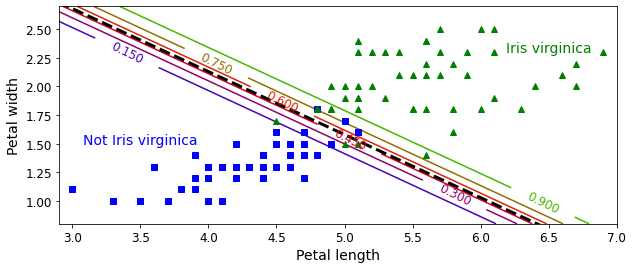

In [60]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

### 4.6.4 소프트맥스 회귀

In [61]:
# 붓꽃을 세 개의 클래스로 분류해 본다.

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C = 10, random_state = 42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Logistic Regression은 클래스가 둘 이상일 때 기본적으로 일대다 전략을 사용한다.  
하지만 multi_class 매개변수를 multinomial로 바꿔주면 소프트맥스 회귀를 사용할 수 있다.  
이때 solver 매개변수에 lbfgs와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해줘야 한다.

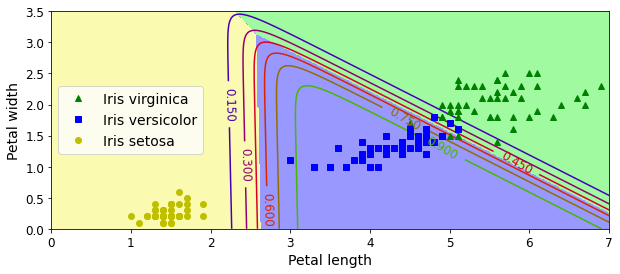

In [62]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()

## 4.7 연습문제
12. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기

In [ ]:
# 앞서 사용한 Iris 데이터셋을 재사용한다.

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

In [ ]:
# 모든 샘플에 편향을 추가한다.

X_with_bias = np.c_[np.ones([len(X), 1]), X]  # X배열의 전체 행 0번째 열에 1을 추가 !

*np.c_
- 두 개의 1차원 배열을 칼럼으로 세로로 붙여서 2차원 배열 만들기

In [ ]:
# 결과를 일정하게 유지하기 위해 랜덤 시드를 지정한다.

np.random.seed(2042)

In [ ]:
# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눈다.
# 보통 train_test_split() 으로 나누지만 이 연습문제에서는 직접 만들어서 풀어본다.

test_ratio = 0.2  # 테스트 세트 사이즈 0.2
validation_ratio = 0.2  # 훈련 세트 내에서 검증 세트 비율 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃은 클래스 인덱스(0, 1, 2)지만 소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 타깃 클래스의 확률이다.  
각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0이다.  
즉, 주어진 샘플에 대한 클래스 확률이 원-핫 벡터다.  
클래스 인덱스를 원-핫 벡터로 바꾸는 간단한 함수를 작성한다.  

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1  # 0, 1, 2 까지니까 총 2+1 , 3개의 클래스가 있다.
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))  # 150x3 크기의 배열을 우선 0으로 채운다.
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

*np.arrange(start, stop, step)
- [start, stop) 에서 step의 크기만큼 일정하게 떨어져있는 숫자들을 array 형태로 반환한다.  
- stop의 매개변수는 반드시 전달되어야 하며 start, step은 꼭 전달되지 않아도 된다.  
- start값이 없다면 0이 기본값이고, step값이 없다면 1이 기본값이다.  

In [ ]:
# 10개의 샘플만 우선 넣어서 테스트해 본다.

y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [ ]:
# 소프트맥스 함수 만들기

def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis = 1, keepdims = True)
    return exps / exp_sums


In [ ]:
# 훈련을 위한 준비를 거의 마쳤다. 입력과 출력의 개수를 정한다.

n_inputs = X_train.shape[1]  # ==3 , 특성 2개와 편향
n_outputs = len(np.unique(y_train))  # ==3 , 3개의 붓꽃 클래스

In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.173284880908112
500 0.8258143504756522
1000 0.6740383508681776
1500 0.5891518016822946
2000 0.5353052890403674
2500 0.4975988211901051
3000 0.469220320068328
3500 0.4467104744290491
4000 0.4281482798645294
4500 0.41238656131534807
5000 0.3986986115898958


In [ ]:
# 소프트맥스 모델을 훈련시켰다.
# 모델 파라미터를 확인해 본다.

Theta

array([[ 2.96506788, -1.31523785, -2.75290651],
       [-0.37388472,  1.16174385,  0.478946  ],
       [-1.0446009 , -0.97856165,  2.04772298]])

In [ ]:
# 검증 세트에 대한 예측과 정확도를 확인한다.

logits = X_valid.dot(Theta) 
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis = 1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

In [ ]:
# 연습을 위해 l2 규제를 추가해 본다.
# 학습률 eta도 증가시켜 본다.

eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.038280239064085
500 0.5322201822520979
1000 0.5035315271928776
1500 0.49465903889629925
2000 0.49128501840330063
2500 0.48989424824341127
3000 0.489296880123749
3500 0.4890341569337251
4000 0.4889169279611998
4500 0.4888641374714865
5000 0.488840222941224


In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

In [ ]:
# 이제 조기 종료를 추가해 본다.
# 매 반복에서 검증 세트에 대한 손실을 계산해서 오차가 증가하기 시작할 때 멈춰야 한다.

eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

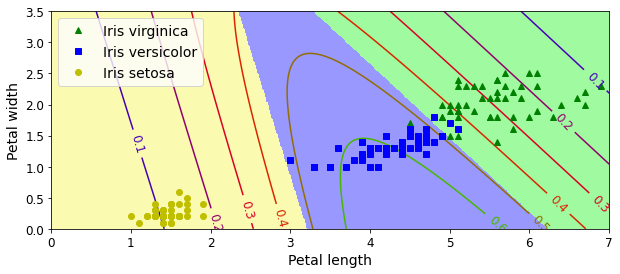

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333